<a href="https://colab.research.google.com/github/guang-zh/ai4genomics_TCGA_Benchmark/blob/master/Copy_of_TCGA_Rihab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload Data

In [0]:
from os.path import join
import os
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PROJ = "My Drive/AI4genomics/TCGA_Benchmark-master" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

In [0]:
from importlib.machinery import SourceFileLoader
TCGA = SourceFileLoader('tcga', join(PROJECT_PATH, 'meta_dataloader/TCGA.py')).load_module()

In [0]:
import sys
import numpy as np
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
%load_ext autoreload
%autoreload 2
import pdb

In [0]:
#Definition de l'ensemble des tasks
tasks = TCGA.TCGAMeta(min_samples_per_class=10)    

/content/drive/My Drive/AI4genomics/TCGA_Benchmark-master/meta_dataloader/TCGA.py:39: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(hdf_file)


In [0]:
# To identify the number of existing tasks in the metaloader
len(tasks)

174

In [0]:
task = TCGA.TCGATask(tasks.task_ids[0])

## Load the dataset (Inputs and Labels) & the train-test steps

In [0]:
def load_all_tasks_sets(tasks):

  if os.path.isfile(join(PROJECT_PATH, 'meta_dataloader/all_X.npy')):
    all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
    all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
    
  else:
    all_X = []
    all_Y = []
    
  cpt = 0

  for taskid in tasks.task_ids:
      cpt += 1
      print(cpt)
        
      task = TCGA.TCGATask(taskid)
      all_X.append(task._samples)
      all_Y.append(task._labels)
        
  all_X = np.concatenate(all_X, axis=0)
  all_Y = np.concatenate(all_Y, axis=0)
        
  np.save(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'), all_X)
  np.save(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'), all_Y)

  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_X, 
                                                                              all_Y, 
                                                                              train_size=0.8,
                                                                              test_size=0.2)
  all_train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
  all_test_set = TensorDataset( Tensor(X_test), Tensor(y_test))
    
  return all_train_set, all_test_set

In [0]:
all_train_set, all_test_set = load_all_tasks_sets(tasks)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


## **Part A - VAE**

# Step 1.1 - Load and preprocess the dataset for the VAE

In [0]:
# You should have train_set instead of X_train as input
# 32 is the max batch size to use 
train_loader = torch.utils.data.DataLoader(all_train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(all_test_set, batch_size=32, shuffle=True)

In [0]:
print(len(train_loader))
print(len(test_loader))

1295
324


# Step 1.2. Define the VAE Model

In [0]:
from torch.nn.utils import spectral_norm
import torch
import torch.nn as nn


class Dummy(torch.nn.Module):
    """
    Helper class that allows you to do nothing. Replaces `lambda x: x`.
    """

    def forward(self, x):
        return x


class LinearBatch(nn.Module):
    """A linear layer with batch normalization."""
    def __init__(self, input_dim, output_dim, bias=True):
        super(LinearBatch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=bias)
        self.batch_norm = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        out = self.linear(x)
        return self.batch_norm(out)


class LinearSpec(nn.Module):
    """A linear layer with spectral normalization."""
    def __init__(self, input_dim, output_dim, bias=True):
        super(LinearSpec, self).__init__()
        self.linear = spectral_norm(nn.Linear(input_dim, output_dim, bias=bias))

    def forward(self, x):
        return self.linear(x)


class LinearLayers(nn.Module):
    """
    A basic feed forward network with configurable dropout and layer-wise
    normalization.
    """
    def __init__(self, layers, dropout=0, norm='none', modulelist=False,
                 bias=True, activate_final=True):
        super(LinearLayers, self).__init__()

        norm_dict = {
            'batch': LinearBatch, 'spectral': LinearSpec, 'none': nn.Linear}

        assert 0 <= dropout < 1
        assert norm in norm_dict.keys()

        # Set up the linear layers.
        self.linear = norm_dict[norm]
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

        arch = []
        n_layers = len(layers)
        for i in range(n_layers-1):
            arch.append(self.linear(layers[i], layers[i+1], bias=bias))

            # Add activation to all layers, except the final one optionally.
            if activate_final or i+1 < n_layers-1:
                arch.append(self.activation)

                # Only dropout the activated layers.
                if dropout > 0:
                    arch.append(self.dropout)

        # Allows for the linear layer to be a passthrough in the case that
        # the number of layers requested is empty or a single value.
        if len(arch) > 0:
            if modulelist:
                self.model = nn.ModuleList(arch)
            else:
                self.model = nn.Sequential(*arch)
        else:
            self.model = Dummy()

    def embed(self, X):
        return self.model(X)

    def forward(self, X):
        return self.embed(X)


class AutoEncoder(nn.Module):
    """
    A basic feed forward classifier architecture with configurable dropout and
    layer-wise normalization.
    """
    def __init__(self, layers, dropout=0, norm='none'):
        """
        An MLP vanilla antoencoder.
        """
        super(AutoEncoder, self).__init__()

        # assert num_classes >= 1
        self.encoder = LinearLayers(layers=layers, dropout=dropout, norm=norm)
        self.decoder = LinearLayers(layers=layers[::-1], dropout=dropout,
                                    norm=norm, activate_final=False)
        self.criterion = torch.nn.MSELoss(reduction='sum')

    def embed(self, x):
        return self.encoder(x)

    def forward(self, x, fingerprint=0, compound=0, line=0):
        z = self.encoder(x)
        X_prime = self.decoder(z)
        return {'z': z, 'x_prime': X_prime, 'x': x}

    def loss(self, outputs):
        recon_loss = self.criterion(outputs['x_prime'], outputs['x'])
        return {'recon_loss': recon_loss}


class VariationalAutoEncoder(nn.Module):
    """
    A basic feed forward classifier architecture with configurable dropout and
    layer-wise normalization with ~*~ variational inference ~*~.
    """
    def __init__(self, layers, beta=1, dropout=0, norm='none'):
        """
        An MLP variational antoencoder.
        """
        super(VariationalAutoEncoder, self).__init__()

        self.encoder = LinearLayers(layers=layers[:-1], dropout=dropout, norm=norm)
        self.mu = LinearLayers(layers=[layers[-2], layers[-1]], activate_final=False)
        self.logvar = LinearLayers(layers=[layers[-2], layers[-1]], activate_final=False)
        self.decoder = LinearLayers(layers=layers[::-1], dropout=dropout,
                                    norm=norm, activate_final=False)
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.beta = beta

    def embed(self, X):
        h = self.encoder(X)
        mu = self.mu(h)
        logvar = self.logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + (std * eps)

        return z

    def decode(self, z):
        x_prime = self.decoder(z)
        return x_prime

    def forward(self, x, fingerprint=0, compound=0, line=0):
        mu, logvar = self.embed(x)
        z = self.reparameterize(mu, logvar)
        x_prime = self.decoder(z)
        return {'z': z, 'x_prime': x_prime, 'x': x, 'mu': mu, 'logvar': logvar}

    def loss(self, outputs):
        recon_loss = self.criterion(outputs['x_prime'], outputs['x'])
        kl_div = -0.5 * torch.sum(1 + outputs['logvar'] - outputs['mu'].pow(2) - outputs['logvar'].exp())

        # Apply beta scaling factor
        kl_div *= self.beta

        return {'recon_loss': recon_loss, 'kl_div': kl_div}


In [0]:
model_VAE = VariationalAutoEncoder(layers=[20530, 100, 50], dropout=0)

In [0]:
model_VAE

VariationalAutoEncoder(
  (encoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=20530, out_features=100, bias=True)
      (1): ReLU()
    )
  )
  (mu): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
    )
  )
  (logvar): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
    )
  )
  (decoder): LinearLayers(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (model): Sequential(
      (0): Linear(in_features=50, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=20530, bias=True)
    )
  )
  (criterion): MSELoss()
)

# Step 1.3. Optimizer for the VAE

In [0]:
"""
The loss was already defined in the VAE, we are only adding the Adam optimizer
"""
import torch.optim as optim

# Define the optimizer, learning rate 
optimizer = optim.Adam(model_VAE.parameters(), lr=0.001)

# Step 1.4. Calculate the VAE training loss and the valid loss

In [0]:
all_training_losses = []

num_epochs = 20

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(train_loader, 0):

#pdb.set_trace()
        # forward propogation
        outputs = model_VAE(inputs)
        
        # calculate the loss
        losses = model_VAE.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
# pdb.set_trace()

        #"ajouter la loss a la fin de liste de toutes les loss (all_losses) avec .append /.detach() « detache » ton tensor torch du graph de computation / .numpy() convertit le tensor en numpy array"
        all_training_losses.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        if i % 1000 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", VAE training cost = " + str(cost))

Epoch:0, Iteration: 0, VAE training cost = 38164588.0
Epoch:0, Iteration: 1000, VAE training cost = 8.219982496040565e+28
Epoch:1, Iteration: 0, VAE training cost = 1.1815930457537686e+29
Epoch:1, Iteration: 1000, VAE training cost = 2.5292516978761753e+29
Epoch:2, Iteration: 0, VAE training cost = 1.5695543417874415e+29
Epoch:2, Iteration: 1000, VAE training cost = 1.8199817197160077e+29
Epoch:3, Iteration: 0, VAE training cost = 9.675532960749765e+28
Epoch:3, Iteration: 1000, VAE training cost = 1.0626142500331535e+29
Epoch:4, Iteration: 0, VAE training cost = 1.189247812927841e+29
Epoch:4, Iteration: 1000, VAE training cost = 1.0079795865882304e+29
Epoch:5, Iteration: 0, VAE training cost = 7.807995688288645e+28
Epoch:5, Iteration: 1000, VAE training cost = 1.4551110957316336e+29
Epoch:6, Iteration: 0, VAE training cost = 2.40062444629975e+29
Epoch:6, Iteration: 1000, VAE training cost = 1.843723700550624e+29
Epoch:7, Iteration: 0, VAE training cost = 1.1383169959627622e+29
Epoch:7,

In [0]:
 # Compute validation error (we don't use the backpropagation and the update of the parametres in the validation error step)
 all_valid_loss= []
 num_epochs = 20
 
 for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(test_loader, 0):
        outputs = model_VAE(inputs)
        
        # calculate the loss
        valid_losses = model_VAE.loss(outputs)
        valid_loss = valid_losses['recon_loss'] + valid_losses['kl_div']
        #pdb.set_trace()

        #Save all the training losses in a list.append /.detach() « detache » ton tensor torch du graph de computation / .numpy() convertit le tensor en numpy array"
        all_valid_loss.append(valid_loss.detach().numpy())

        # print statistics
        cost = valid_loss.item()
        if i % 300 == 0:    # print every 300 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", VAE valid cost = " + str(cost))
            
    #print(np.mean(all_valid_loss)) "doesn't seem to work"

Epoch:0, Iteration: 0, VAE valid cost = 1.4646668043097204e+29
Epoch:0, Iteration: 300, VAE valid cost = 1.3405686799796855e+29
Epoch:1, Iteration: 0, VAE valid cost = 9.288649308747483e+28
Epoch:1, Iteration: 300, VAE valid cost = 8.484431241188079e+28
Epoch:2, Iteration: 0, VAE valid cost = 1.7999488744116968e+29
Epoch:2, Iteration: 300, VAE valid cost = 1.8633655339101532e+29
Epoch:3, Iteration: 0, VAE valid cost = 1.5667750402176134e+29
Epoch:3, Iteration: 300, VAE valid cost = 2.6835174326667374e+29
Epoch:4, Iteration: 0, VAE valid cost = 1.2046695507036188e+29
Epoch:4, Iteration: 300, VAE valid cost = 2.7471248757711017e+29
Epoch:5, Iteration: 0, VAE valid cost = 2.118900151189943e+29
Epoch:5, Iteration: 300, VAE valid cost = 1.275276107619574e+29
Epoch:6, Iteration: 0, VAE valid cost = 9.02345065180249e+28
Epoch:6, Iteration: 300, VAE valid cost = 1.3464698435840091e+29
Epoch:7, Iteration: 0, VAE valid cost = 1.2437621504747806e+29
Epoch:7, Iteration: 300, VAE valid cost = 2.472

# Step 1.5. Visualize the VAE loss history

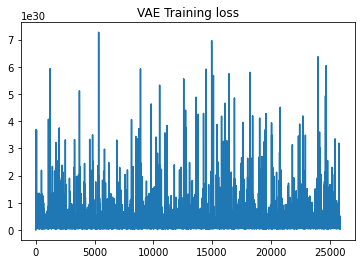

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

plt.plot(all_training_losses)
plt.title("VAE Training loss")
plt.show()

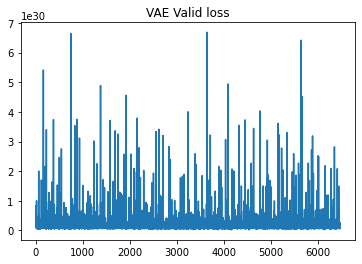

In [0]:
plt.plot(all_valid_loss)
plt.title("VAE Valid loss")
plt.show()

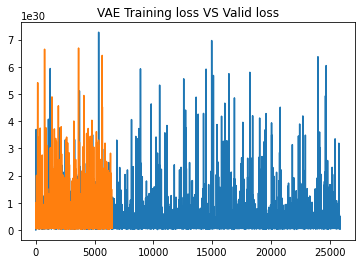

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

plt.plot(all_training_losses)
plt.plot(all_valid_loss)
plt.title("VAE Training loss VS Valid loss")
plt.show()

## **Part B - The CVAE**

# Step 2.1. Load and preprocess the dataset for the CVAE

Define the "one_hot vector" that will append the Task_ID

In [0]:
def load_all_one_hot(tasks):
  if os.path.isfile(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy')):
    all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))
  
  else:

  all_one_hot = []
  new_one_hot = []
  
  cpt = 0
      
  for taskid in tasks.task_ids:
        
    one_hot = np.zeros((1,174))
    one_hot[0, cpt] = 1
    cpt += 1
    print(cpt, one_hot)

    #to use only when there is a need to limit the number of tasks
    #if cpt > 5:
      #break
        
    task = TCGA.TCGATask(taskid)
    new_one_hot.append(one_hot)
    
    for j in range(0, len(task._samples)):
      all_one_hot.append(new_one_hot[cpt-1])
    

  #all_one_hot = np.concatenate(all_one_hot, axis=0)
  np.save(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'), all_one_hot)

  return all_one_hot 

In [0]:
all_one_hot = load_all_one_hot(tasks)

1 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
2 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0

Load_all_tasks_conditions_sets and define the new output (All_X_one_hot)

In [0]:
def load_all_tasks_conditions_sets(tasks):
  # When task ID is provided, each sample should be a vector [gene1, gene2, ...., gene20k, 0, 0, 0, 0, 1, 0, 0]
  # How to compute one hot encoding of the ith task [0, 0, 0, 0, 1, 0, 0]?? vector zero everywhere but in the ith index
  # one_hot = np.zeros(174)
  # one_hot[cpt] = 1

    # Here we load the arrays if they have been saved already
    #if os.path.isfile(join(PROJECT_PATH, 'meta_dataloader/all_X.npy')):
    all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
    all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
    all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))
    #else:

      #all_X = []
      #all_Y = []
      #X_one_hot = []
      #all_X_one_hot = []

      #cpt = 0

      #for taskid in tasks.task_ids:
        
        #one_hot = np.zeros((1,174))
        #one_hot[0, cpt] = 1
        #cpt += 1
        #print(cpt, one_hot)

        #to use only when there is a need to limit the number of tasks
        #if cpt > 5:
          #break
        
        #task = TCGA.TCGATask(taskid)
        #all_X.append(task._samples)
        #all_Y.append(task._labels)

      #all_X = np.concatenate(all_X, axis=0)
      #all_Y = np.concatenate(all_Y, axis=0)

      #np.save(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'), all_X)
      #np.save(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'), all_Y)
      
      #all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))

      for i in range(0, len(all_X)):
          X_one_hot = np.append(all_X[i], all_one_hot[i], axis=0)
          all_X_one_hot.append(X_one_hot)

          np.save(join(PROJECT_PATH, 'meta_dataloader/all_X_one_hot.npy'), all_X_one_hot)

        
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_X_one_hot,
                                                                              all_Y, 
                                                                              train_size=0.8,
                                                                              test_size=0.2)
  all_train_conditions_set = TensorDataset( Tensor(X_train), Tensor(y_train))
  all_test_conditions_set = TensorDataset( Tensor(X_test), Tensor(y_test))
    
  return all_train_conditions_set, all_test_conditions_set

In [0]:
def load_all_tasks_conditions_sets(tasks):
  all_X = np.load(join(PROJECT_PATH, 'meta_dataloader/all_X.npy'))
  all_Y = np.load(join(PROJECT_PATH, 'meta_dataloader/all_Y.npy'))
  all_one_hot = np.load(join(PROJECT_PATH, 'meta_dataloader/all_one_hot.npy'))

  all_X_one_hot = []
  X_one_hot = []

  for i in range(0, len(all_X)):
    X_one_hot = np.append(all_X[i], all_one_hot[i], axis=0)
    all_X_one_hot.append(X_one_hot)
    all_X_one_hot = np.concatenate(all_X_one_hot, axis=0)

  np.save(join(PROJECT_PATH, 'meta_dataloader/all_X_one_hot.npy'), all_X_one_hot)

  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(all_X_one_hot,
                                                                              all_Y, 
                                                                              train_size=0.8,
                                                                              test_size=0.2)
  all_train_conditions_set = TensorDataset( Tensor(X_train), Tensor(y_train))
  all_test_conditions_set = TensorDataset( Tensor(X_test), Tensor(y_test))
  return all_train_conditions_set, all_test_conditions_set

In [0]:
all_train_conditions_set, all_test_conditions_set = load_all_tasks_conditions_sets(tasks)

In [0]:
# You should have train_set instead of X_train as input
# 32 is the max batch size to use 
train_CVAE_loader = torch.utils.data.DataLoader(all_train_conditions_set, batch_size=32, shuffle=True)
test_CVAE_loader = torch.utils.data.DataLoader(all_test_conditions_set, batch_size=32, shuffle=True)

NameError: ignored

In [0]:
print(train_CVAE_loader.shape)

In [0]:
print(len(train_CVAE_loader))
print(len(test_CVAE_loader))

# Step 2.2. : Define the CVAE model

Updated Auto-encoder code provided by Paul


In [0]:
from torch.nn.utils import spectral_norm
import torch
import torch.nn as nn


class Dummy(torch.nn.Module):
    """
    Helper class that allows you to do nothing. Replaces `lambda x: x`.
    """

    def forward(self, x):
        return x


class LinearBatch(nn.Module):
    """A linear layer with batch normalization."""
    def __init__(self, input_dim, output_dim, bias=True):
        super(LinearBatch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=bias)
        self.batch_norm = nn.BatchNorm1d(output_dim)

    def forward(self, x):
        out = self.linear(x)
        return self.batch_norm(out)


class LinearSpec(nn.Module):
    """A linear layer with spectral normalization."""
    def __init__(self, input_dim, output_dim, bias=True):
        super(LinearSpec, self).__init__()
        self.linear = spectral_norm(nn.Linear(input_dim, output_dim, bias=bias))

    def forward(self, x):
        return self.linear(x)


class LinearLayers(nn.Module):
    """
    A basic feed forward network with configurable dropout and layer-wise
    normalization.
    """
    def __init__(self, layers, dropout=0, norm='none', modulelist=False,
                 bias=True, activate_final=True):
        super(LinearLayers, self).__init__()

        norm_dict = {
            'batch': LinearBatch, 'spectral': LinearSpec, 'none': nn.Linear}

        assert 0 <= dropout < 1
        assert norm in norm_dict.keys()

        # Set up the linear layers.
        self.linear = norm_dict[norm]
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

        arch = []
        n_layers = len(layers)
        for i in range(n_layers-1):
            arch.append(self.linear(layers[i], layers[i+1], bias=bias))

            # Add activation to all layers, except the final one optionally.
            if activate_final or i+1 < n_layers-1:
                arch.append(self.activation)

                # Only dropout the activated layers.
                if dropout > 0:
                    arch.append(self.dropout)

        # Allows for the linear layer to be a passthrough in the case that
        # the number of layers requested is empty or a single value.
        if len(arch) > 0:
            if modulelist:
                self.model = nn.ModuleList(arch)
            else:
                self.model = nn.Sequential(*arch)
        else:
            self.model = Dummy()

    def embed(self, X):
        return self.model(X)

    def forward(self, X):
        return self.embed(X)


class AutoEncoder(nn.Module):
    """
    A basic feed forward classifier architecture with configurable dropout and
    layer-wise normalization.
    """
    def __init__(self, layers, dropout=0, norm='none'):
        """
        An MLP vanilla antoencoder.
        """
        super(AutoEncoder, self).__init__()

        # assert num_classes >= 1
        self.encoder = LinearLayers(layers=layers, dropout=dropout, norm=norm)
        self.decoder = LinearLayers(layers=layers[::-1], dropout=dropout,
                                    norm=norm, activate_final=False)
        self.criterion = torch.nn.MSELoss(reduction='sum')

    def embed(self, x):
        return self.encoder(x)

    def forward(self, x, fingerprint=0, compound=0, line=0):
        z = self.encoder(x)
        X_prime = self.decoder(z)
        return {'z': z, 'x_prime': X_prime, 'x': x}

    def loss(self, outputs):
        recon_loss = self.criterion(outputs['x_prime'], outputs['x'])
        return {'recon_loss': recon_loss}


class VariationalAutoEncoder(nn.Module):
    """
    A basic feed forward classifier architecture with configurable dropout and
    layer-wise normalization with ~*~ variational inference ~*~.
    """
    def __init__(self, layers, beta=1, dropout=0, norm='none'):
        """
        An MLP variational antoencoder.
        """
        super(VariationalAutoEncoder, self).__init__()

        self.encoder = LinearLayers(layers=layers[:-1], dropout=dropout, norm=norm)
        self.mu = LinearLayers(layers=[layers[-2], layers[-1]], activate_final=False)
        self.logvar = LinearLayers(layers=[layers[-2], layers[-1]], activate_final=False)
        self.decoder = LinearLayers(layers=layers[::-1], dropout=dropout,
                                    norm=norm, activate_final=False)
        self.criterion = torch.nn.MSELoss(reduction='sum')
        self.beta = beta

    def embed(self, X):
        h = self.encoder(X)
        mu = self.mu(h)
        logvar = self.logvar(h)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        z = mu + (std * eps)

        return z

    def decode(self, z):
        x_prime = self.decoder(z)
        return x_prime

    def forward(self, x, fingerprint=0, compound=0, line=0):
        mu, logvar = self.embed(x)
        z = self.reparameterize(mu, logvar)
        x_prime = self.decoder(z)
        return {'z': z, 'x_prime': x_prime, 'x': x, 'mu': mu, 'logvar': logvar}

    def loss(self, outputs):
        recon_loss = self.criterion(outputs['x_prime'], outputs['x'])
        kl_div = -0.5 * torch.sum(1 + outputs['logvar'] - outputs['mu'].pow(2) - outputs['logvar'].exp())

        # Apply beta scaling factor
        kl_div *= self.beta

        return {'recon_loss': recon_loss, 'kl_div': kl_div}


In [0]:
model_CVAE = VariationalAutoEncoder(layers=[20530, 100, 50], dropout=0)

In [0]:
model_CVAE

# Step 2.3. Optimizer step (learning rate)





In [0]:
"""
The loss was already defined in the VAE, we are only adding the Adam optimizer
"""
import torch.optim as optim

# Define the optimizer, learning rate 
optimizer = optim.Adam(model_CVAE.parameters(), lr=0.0001)

# Step 2.4. - Calculate the CVAE training loss and the valid loss

In [0]:
all_training_losses = []
num_epochs = 20

for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(train_CVAE_loader, 0):

#pdb.set_trace()
        # forward propogation
        outputs = model(inputs)
        
        # calculate the loss
        losses = model.loss(outputs)
        loss = losses['recon_loss'] + losses['kl_div']
# pdb.set_trace()

        #"ajouter la loss a la fin de liste de toutes les loss (all_losses) avec .append /.detach() « detache » ton tensor torch du graph de computation / .numpy() convertit le tensor en numpy array"
        all_training_losses.append(loss.detach().numpy())

        # backpropogation + update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", CVAE training cost = " + str(cost))


In [0]:
 # Compute validation error (we don't use the backpropagation and the update of the parametres in the validation error step)
 all_valid_loss= []
 num_epochs = 20

 for epoch in range(num_epochs): 
      for i, (inputs, labels) in enumerate(test_CVAE_loader, 0):
        outputs = model(inputs)
        
        # calculate the loss
        valid_losses = model.loss(outputs)
        valid_loss = valid_losses['recon_loss'] + valid_losses['kl_div']
        #pdb.set_trace()

        #Save all the training losses in a list.append /.detach() « detache » ton tensor torch du graph de computation / .numpy() convertit le tensor en numpy array"
        all_valid_loss.append(valid_loss.detach().numpy())

        # print statistics
        cost = valid_loss.item()
        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", CVAE valid cost = " + str(cost))
            
    #print(np.mean(all_valid_loss)) "doesn't seem to work"

# 2.5. Visualize the CVAE loss

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

plt.plot(all_training_losses)
plt.title("CVAE Training loss")
plt.show()


In [0]:
plt.plot(all_valid_loss)
plt.title("CVAE Valid loss")
plt.show()

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

plt.plot(all_training_losses)
plt.plot(all_valid_loss)
plt.title("CVAE Training loss VS Valid loss")
plt.show()

## TODO

- Compute the valid loss and plot the valid loss in another plot (separated from the training loss) - Done but only for the 4 first tasks

- Clean the code #Rihab- Done

- Modify the load_all_tasks_sets function in order to return the ID of the task for each sample -- Not done yet

- Figure out what is the difference between conditional VAE and VAE, and send your answer to Paul for validation


    #Rihab response:
    **Difference Autoencoder VS Variational Autoencoder**: VAE works by making the latent space more predictable, more continuous, less sparse. By forcing latent variables to become normally distributed, VAEs gain control over the latent space.
    **Difference VAE VS CVAE**: CVAE allows modeling the input based on both the latent variables (like the VAE), but also to based on an additional information such the Task_ID or Task_name in the TCGA_Benchmark case.
    Ref: https://towardsdatascience.com/variational-autoencoders-vaes-for-dummies-step-by-step-tutorial-69e6d1c9d8e9

- modify (DO NOT TAKE ANYTHING FROM OUTSIDE) the VAE code in order to have a conditional VAE code. (it should be around 2 lines of code to add)

    #Rihab - Code lines to use

    In the encoder: 
    X = Input(batch_shape=())
    cond = Input(batch_shape=())
    inputs = merge([X, cond], mode='concat', concat_axis=1)
    
    In the decoder: 
    z_cond = merge([z, cond], mode='concat', concat_axis=1)

- Tweak learning rate (lr parameter in the optimizer), number of epochs, architecture of the VAE etc in order to have a "good" final valid loss. (do not spend too much time on this)

## Step 6 -  Definition of the evaluation metrics

We will use accuracy as an evaluation metric

## Step 7 - Report results on the train and test data (using the evaluation metric)

Various Models
*   CNN: spatial data & many filters
*   GAN: generator & discriminator
*   AE: Encoder & Decoder, features learned through compressions
*   VAE: trade-off of latent loss & reconstruction loss; hidden neurons fit into a specific distribution
*   cVAE: latent variables, data, both conditioned to some random variables

*   VAE vs AE: VAE added the distribution fitting & latent vector
*   VAE vs cVAE: cVAE added the conditions using one-hot vectors